# Classification
- we'll be continuing our discussion on Tensorflow syntax
- this time real data instead of synthetic
- we' look at binary classification like spam not spam
- recall we have X matrix by NxD and a target vector Nx1
- since it's a binary classification the target vector (output) will only contain ones and zeroes
- The X Matrix will be TFIDF for now but we'll learn how to get rid of it later in this course

### Classification vs Regression (Model Building & Compile)
- ipad'e çiziyorum
- recall: dense layer makes a fine transofrmation. In linear case, it's a linear transformation m*x + b
- In logistic regreassion we apply a sigmoid unction after this transformation, that maps the output to a probability between zero and one.
- in Tensorflow you don't have to write this function yourself but instead passing a string called "sigmoid" which automatically applies sigmoid after doing the w.T transpose
- In the classification case, in compile method, we use binary_crossentropy for loss
- you can check extra readings to find out why
- the last parameter is metrics: remember in classification what we're mostly interested is accuracy, when you pass accuracy as a argument, it means when you call the fit method, both the cross entropy and accuracy will be computed

- For those who are curious, formula for binary cross entropy (in ipad)
- loss function, prediction doğruyken zero olmalı, prediction yanlışken sonsuza yaklaşmalı, bunu sağlıyo bu fonksiyon

## Code Preparation

- yet this previous syntax has problems with numerical stability, what we'll actually do is a bit more complex
- intuitivly we know functions with exponentials and logs are a bit unstable because they make numbers to explode to infinity or approach to zzero
- the sigmoid involves exponentials and cross entropy involves logs (ipad)
- So they effectively cancel each other out
- There is a way to combine sigmoid and the subsequent loss function and make the computations numerically more stable!
- just understand the syntax

#### This new syntax looks exactly the same as the linear regression model without any sigmoid
- we call the outputs logits, connected with the fact that sigmoid is called logistic function
- next change comes from how we compile:

#### Note that in the above example, for the loss function we passed the cross entropy as string but only because we were ok with its default values, now we're not ok with default values. We have to tell Tensorflow that the loss function should be combined with sigmoid
- to this we create an object BinaryCrossentropy() and pass from_logits argument True

#### Note when we use this method, when we call the model that predicts, the values ill be logits, which can be any value, instead of probabilities, which can be only between zero and one

All the subsequent steps remain samee

## Exercise: Binary Classification with Tensorflow
Dataset: tweets about airlines

In [1]:
# https://www.kaggle.com/crowdflower/twitter-airline-sentiment
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv
    

--2023-06-16 12:03:35--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/csv]
Saving to: 'AirlineTweets.csv'

AirlineTweets.csv   100%[===================>]   3.26M  1.90MB/s    in 1.7s    

2023-06-16 12:03:38 (1.90 MB/s) - 'AirlineTweets.csv' saved [3421431/3421431]



In [2]:
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

2023-06-16 12:04:29.866278: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
np.random.seed(0)
tf.random.set_seed(0) #bu?

In [4]:
df = pd.read_csv('AirlineTweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


<AxesSubplot:>

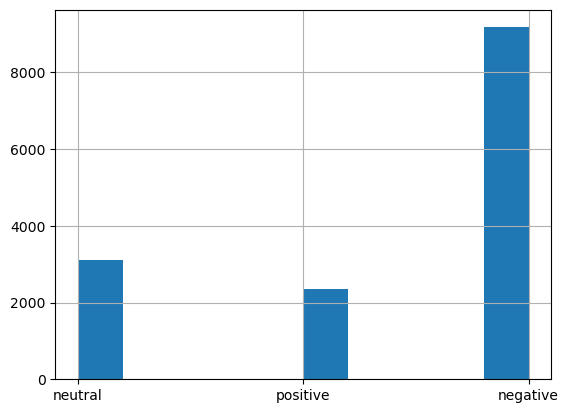

In [5]:
df = df[['airline_sentiment', 'text']]
df["airline_sentiment"].hist()

In [6]:
df = df[df['airline_sentiment'] != 'neutral'].copy() #ignore the neutral class

In [7]:
target_map = {'positive': 1, 'negative': 0}
df['target'] = df['airline_sentiment'].map(target_map)
df.head()

# DL works with numbers so this is needed
# unlike sklearn there is no functionality to do this conversion internally

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [8]:
df_train, df_test = train_test_split(df, random_state=42)

In [12]:
vectorizer = TfidfVectorizer(max_features=2000)
X_train = vectorizer.fit_transform(df_train['text'])
X_test = vectorizer.transform(df_test['text'])

In [13]:
# data must not be sparse matrix before passing into tensorflow
#tensorflow does not know how to deal with tf-idf matricses
X_train = X_train.toarray() #convert them to np arrays, since we only keep 2000 features, this is not an issue
#diğer türlü issue mü olurdu
X_test = X_test.toarray()

Y_train = df_train['target']
Y_test = df_test['target']

In [31]:
# get number of input dimensions for our model, which is the number of columns in X_train
# niye kolon?
D = X_train.shape[1]
X_train.shape

(8655, 2000)

In [15]:
# build model
i = Input(shape=(D,))
x = Dense(1)(i) # sigmoid included in loss

model = Model(i, x)
model.summary()

#we have 2001 parameters in dense layer : 2000 columns and 1 bias term

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1)                 2001      
                                                                 
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(
  loss=BinaryCrossentropy(from_logits=True),
  optimizer=Adam(learning_rate=0.01),
  metrics=['accuracy']
)

In [17]:
r = model.fit(
  X_train, Y_train,
  validation_data=(X_test, Y_test), #this argument is where you pass your out of sample data, 
    #so metrics can be computed at the end of each epoch
  epochs=40,
  batch_size=128,
)

Epoch 1/40
68/68 [==============================] - 1s 6ms/step - loss: 0.5028 - accuracy: 0.7920 - val_loss: 0.3971 - val_accuracy: 0.8049
Epoch 2/40
68/68 [==============================] - 0s 4ms/step - loss: 0.3756 - accuracy: 0.7969 - val_loss: 0.3391 - val_accuracy: 0.8222
Epoch 3/40
68/68 [==============================] - 0s 3ms/step - loss: 0.3220 - accuracy: 0.8183 - val_loss: 0.3026 - val_accuracy: 0.8423
Epoch 4/40
68/68 [==============================] - 0s 4ms/step - loss: 0.2848 - accuracy: 0.8455 - val_loss: 0.2768 - val_accuracy: 0.8600
Epoch 5/40
68/68 [==============================] - 0s 4ms/step - loss: 0.2574 - accuracy: 0.8644 - val_loss: 0.2581 - val_accuracy: 0.8780
Epoch 6/40
68/68 [==============================] - 0s 4ms/step - loss: 0.2366 - accuracy: 0.8809 - val_loss: 0.2443 - val_accuracy: 0.8888
Epoch 7/40
68/68 [==============================] - 0s 5ms/step - loss: 0.2201 - accuracy: 0.8927 - val_loss: 0.2335 - val_accuracy: 0.9002
Epoch 8/40
68/68 [==

#### Notice in each epoch we're getting info on train loss & train accuracy and validation loss & validation accuracy

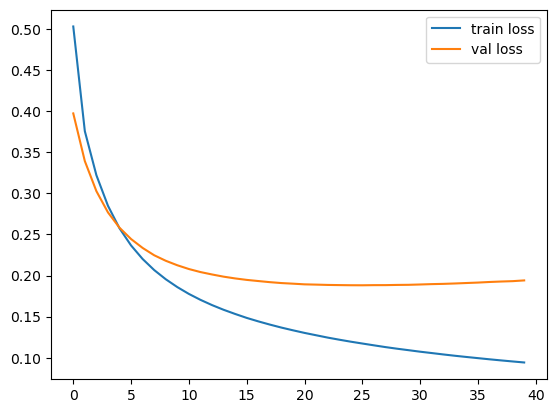

In [18]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

#notice how validation loss doesn't go smaller in each step
# as usual ML models perform better on train data than test data


#### Notice how val_loss started increasing a bit in the later epochs, this could suggest a bit of overfitting
#### In order to rectify this, we can use a callback to save the best model from the history of training according to the val_loss

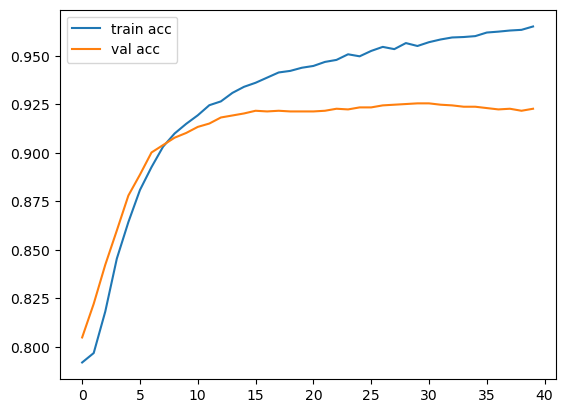

In [19]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

## again we see the same pattern, accuracy stop increasing for test_set after some point and lately a bit decrease

In [20]:
## Next: get our models predictions, bcz outputs are logits but not probabilities, we won't round the outputs 
#but rather check whether they are bigger or not than zero
# after that we get an array of trues and falses, which we wanna convert into numbers so we multiply by 1.
#finally we call flatten so that ptrain and ptest will become one dimensional arrays

P_train = ((model.predict(X_train) > 0) * 1.0).flatten()
P_test = ((model.predict(X_test) > 0) * 1.0).flatten()

cm = confusion_matrix(Y_train, P_train, normalize='true')
cm

91/91 [==============================] - 0s 2ms/step


array([[0.99110139, 0.00889861],
       [0.09833333, 0.90166667]])

Mathematically, the logit function is defined as:

logit(p) = log(p / (1 - p))

Where:

"p" is the probability of the event occurring (e.g., the probability of a positive outcome in binary classification).
- haliyle p > p' ise p/1-p > 1, log (>1) positif bi sayı, yani logit is positive
- p < p' p/1-p < 1 log(<1) negatif bi sayı, logit is negative

### soru: e peki ben 0.5 yerine başka bi threshold istediysem nolcak. ona dair logit'i hesaplayıp ordan transform etcem galiba

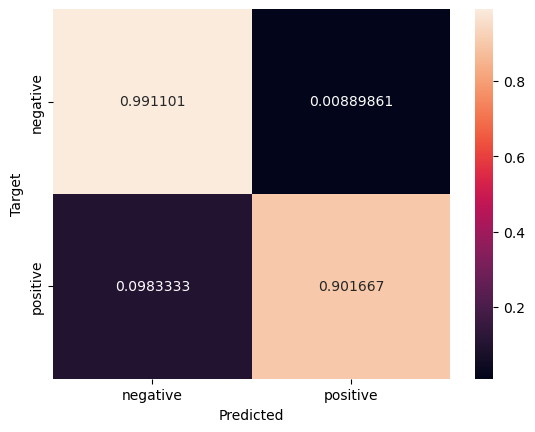

In [21]:
# Scikit-Learn is transitioning to V1 but it's not available on Colab
# The changes modify how confusion matrices are plotted
def plot_cm(cm):
  classes = ['negative', 'positive']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

plot_cm(cm)

## As expected we see a better performance for the negative class, which is the overrepresented class
# TN > TP

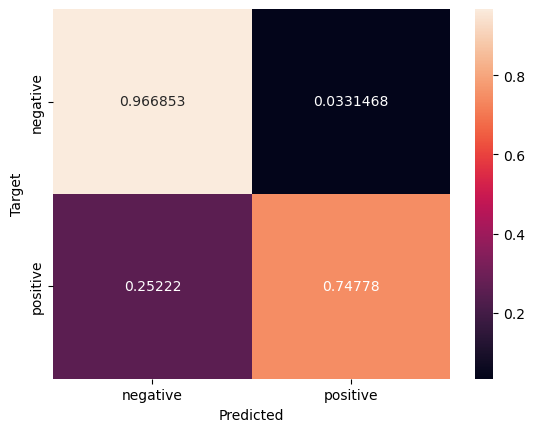

In [22]:
cm_test = confusion_matrix(Y_test, P_test, normalize='true')
plot_cm(cm_test)

In [23]:
### since it's inbalanced dataset, we should compute other metrics like AUC
#ay bunu da her epoch'da hesaplatamaz mıydık compile ederken yazıp?
Pr_train = model.predict(X_train)
Pr_test = model.predict(X_test)
print("Train AUC:", roc_auc_score(Y_train, Pr_train))
print("Test AUC:", roc_auc_score(Y_test, Pr_test))

print("Train F1:", f1_score(Y_train, P_train))
print("Test F1:", f1_score(Y_test, P_test))

91/91 [==============================] - 0s 3ms/step
Train AUC: 0.9950082664721615
Test AUC: 0.9547195433111927


In [25]:
model.layers
model.layers[1].get_weights()

[array([[-3.7506492],
        [ 3.3090355],
        [-1.5858383],
        ...,
        [ 2.0611084],
        [ 1.6166893],
        [-2.923192 ]], dtype=float32),
 array([-0.24304554], dtype=float32)]

In [30]:
w = model.layers[1].get_weights()[0] #en sondaki bias'a ait olan array'i çıkardık bu sayede galiba
w

array([[-3.7506492],
       [ 3.3090355],
       [-1.5858383],
       ...,
       [ 2.0611084],
       [ 1.6166893],
       [-2.923192 ]], dtype=float32)

In [27]:
word_index_map = vectorizer.vocabulary_
word_index_map

{'jetblue': 973,
 'thanks': 1726,
 'for': 753,
 'having': 855,
 'us': 1859,
 'hang': 838,
 'out': 1262,
 'at': 197,
 'tampa': 1708,
 'airport': 122,
 'forever': 756,
 'today': 1767,
 'it': 964,
 'really': 1420,
 'been': 243,
 'an': 147,
 'awesome': 217,
 'experience': 654,
 'americanair': 143,
 'was': 1898,
 'told': 1770,
 'you': 1993,
 'could': 452,
 'only': 1245,
 'refund': 1434,
 'me': 1107,
 'the': 1730,
 'cost': 448,
 'of': 1224,
 'my': 1179,
 'original': 1254,
 'return': 1476,
 'flight': 726,
 'note': 1211,
 'had': 828,
 'booked': 273,
 'more': 1164,
 'expensive': 653,
 'everyone': 635,
 'else': 602,
 'outstanding': 1267,
 'united': 1842,
 'denver': 516,
 'to': 1766,
 'austin': 207,
 'still': 1660,
 'on': 1239,
 'ground': 820,
 'issue': 961,
 'is': 959,
 'lack': 999,
 'announcement': 151,
 'made': 1086,
 'so': 1606,
 'late': 1010,
 'when': 1929,
 'gate': 793,
 'agent': 113,
 'there': 1734,
 'over': 1268,
 'hour': 897,
 'southwestair': 1626,
 'hold': 880,
 '30': 36,
 'min': 1141,


In [28]:
# let's look at the weights for each word
# try it with different threshold values!
threshold = 2

print("Most positive words:")
word_weight_tuples = []
for word, index in word_index_map.items():
    weight = w[index, 0]
    if weight > threshold:
        word_weight_tuples.append((word, weight))

word_weight_tuples = sorted(word_weight_tuples, key=lambda x: -x[1]) #ay bu nasıl bi sorting
#x[1] diyince wieght'e göre sırala - olması tersten yapıyo

for i in range(10):
  word, weight = word_weight_tuples[i]
  print(word, weight)

Most positive words:
thank 9.737547
thanks 9.339872
worries 8.385686
great 7.9430594
awesome 7.365819
love 7.2719393
excellent 7.083945
kudos 6.655065
amazing 6.4798703
best 6.1265254


In [29]:
print("Most negative words:")
word_weight_tuples = []
for word, index in word_index_map.items():
    weight = w[index, 0]
    if weight < -threshold:
        word_weight_tuples.append((word, weight))

word_weight_tuples = sorted(word_weight_tuples, key=lambda x: x[1])
for i in range(10):
  word, weight = word_weight_tuples[i]
  print(word, weight)
    
    
#instead of printing all the words above the threshold, he decied to print top-10 words
# la o zaman threshold'un ne anlamı kaldı ki? direkt sort edip top-10 yapardık
#kendi de aynı şeyi dedi :D


Most negative words:
worst -9.316172
paid -7.7095265
not -7.6675887
rude -7.6092896
disappointed -7.2309017
nothing -6.8265276
website -6.807978
hung -6.7175364
instead -6.5947933
worse -6.203037


In [ ]:
### Exercise: apply this to spam detection